<a href="https://colab.research.google.com/github/TheCaveOfAdullam/2026-reserch-1/blob/main/new_model_save_test20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch_pruning
!pip install ptflops
!pip install fvcore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=8f62cf005995107cae08366b8328d050553076ed63d7de612cc2f2dfbfb4f328
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=84f988eccc7668c1f562c1155a5a15d5425e7a41370a4fbef3b304551e557ba2
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built fvcore iopath


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F # 추가됨.
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix
import torch.nn.utils.prune as prune
import torch_pruning as tp
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm
from ptflops import get_model_complexity_info
import time
import random

In [ ]:
seed = 52
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # GPU 사용 시
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
categories = ['normal', 'fault_BB', 'fault_RI', 'fault_SM', 'fault_BELT']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===== 저장된 데이터 로딩용 Dataset =====
class PreprocessedDataset(Dataset):
    def __init__(self, pt_file):
        data = torch.load(pt_file, weights_only=False)
        self.X = data['X']
        self.y = data['y']

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = self.X[idx].T
        y = self.y[idx]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# ===== CSV 읽기 없이 바로 로딩 =====
train_dataset = PreprocessedDataset('/content/drive/MyDrive/11kw pro data/train_processed.pt')
val_dataset   = PreprocessedDataset('/content/drive/MyDrive/11kw pro data/val_processed.pt')
test_dataset  = PreprocessedDataset('/content/drive/MyDrive/11kw pro data/test_processed.pt')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

print("빠른 데이터 로딩 완료!")

빠른 데이터 로딩 완료!


In [ ]:
class CNNModel(nn.Module):
    def __init__(self, input_length):
        super(CNNModel, self).__init__()

        # --- Convolution layers ---
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=0)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        # --- Flatten 후 크기 계산 ---
        with torch.no_grad():
            sample_input = torch.zeros(1, 1, input_length)
            sample_output = self.forward_conv_layers(sample_input)
            conv_output_size = sample_output.size(1) * sample_output.size(2)

        # --- Fully Connected ---
        self.fc1 = nn.Linear(conv_output_size, 256)
        self.dropout = nn.Dropout(0.4)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, len(categories))

    def forward_conv_layers(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        return x

    def forward(self, x):
        x = self.forward_conv_layers(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.bn1(x)
        x = self.fc2(x)
        return x

In [ ]:
# 모델 학습 함수 (학습 곡선 기록 추가)
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5, max_norm=1.0):
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_loader_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, labels in train_loader_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            train_loader_iter.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    # 학습 곡선 시각화
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

    return model

In [ ]:
# 모델 평가 함수
def evaluate_model(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 샘플 수 기반의 loss 계산
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 전체 샘플 수로 나눔 → 샘플 평균 Loss
    average_val_loss = val_loss / total
    val_accuracy = 100 * correct / total

    return average_val_loss, val_accuracy

# 모델 크기 계산
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    model_size = (param_size + buffer_size) / 1024**2  # Convert to MB
    return model_size

In [ ]:
# F1 스코어 계산
def calculate_f1_score(model, loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    print(f"F1 Score: {f1:.4f}")

In [ ]:
# 비제로 가중치 계산 함수
def count_nonzero_weights(model):
    nonzero_count = 0
    total_count = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            nonzero_count += torch.sum(param != 0).item()
            total_count += param.numel()
    return nonzero_count, total_count

In [ ]:
# 모델 초기화 및 학습 설정
# Determine input_length from the dataset
# Assuming the first element of train_dataset returns a tensor of shape (sequence_length,)
first_input_sample, _ = train_dataset[0]
input_length = first_input_sample.shape[1]

model = CNNModel(input_length=input_length)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4) # weight_decay 값을 조정하여 L2 정규화 강도 설정

In [ ]:
# 모델 크기 출력
model_size = get_model_size(model)
print(f'Model size: {model_size:.2f} MB')

Model size: 11.73 MB


Epoch 1/15: 100%|██████████| 2625/2625 [00:21<00:00, 123.18batch/s, accuracy=64.1, loss=0.783]


Epoch [1/15], Loss: 1.0732, Accuracy: 64.12%, Val Loss: 0.9293, Val Accuracy: 60.00%


Epoch 2/15: 100%|██████████| 2625/2625 [00:18<00:00, 139.40batch/s, accuracy=94.2, loss=0.488]


Epoch [2/15], Loss: 0.6348, Accuracy: 94.22%, Val Loss: 0.6514, Val Accuracy: 83.67%


Epoch 3/15: 100%|██████████| 2625/2625 [00:19<00:00, 136.12batch/s, accuracy=98.7, loss=0.245]


Epoch [3/15], Loss: 0.3544, Accuracy: 98.74%, Val Loss: 0.4633, Val Accuracy: 83.79%


Epoch 4/15: 100%|██████████| 2625/2625 [00:20<00:00, 128.00batch/s, accuracy=99.2, loss=0.147]


Epoch [4/15], Loss: 0.1949, Accuracy: 99.16%, Val Loss: 0.2623, Val Accuracy: 97.14%


Epoch 5/15: 100%|██████████| 2625/2625 [00:18<00:00, 141.09batch/s, accuracy=99.4, loss=0.061]


Epoch [5/15], Loss: 0.1150, Accuracy: 99.41%, Val Loss: 0.2211, Val Accuracy: 92.59%


Epoch 6/15: 100%|██████████| 2625/2625 [00:18<00:00, 140.73batch/s, accuracy=99.5, loss=0.0421]


Epoch [6/15], Loss: 0.0743, Accuracy: 99.50%, Val Loss: 0.1737, Val Accuracy: 95.86%


Epoch 7/15: 100%|██████████| 2625/2625 [00:19<00:00, 137.47batch/s, accuracy=99.6, loss=0.0141]


Epoch [7/15], Loss: 0.0512, Accuracy: 99.60%, Val Loss: 0.1294, Val Accuracy: 96.55%


Epoch 8/15: 100%|██████████| 2625/2625 [00:18<00:00, 140.38batch/s, accuracy=99.6, loss=0.0145]


Epoch [8/15], Loss: 0.0376, Accuracy: 99.61%, Val Loss: 0.0643, Val Accuracy: 99.06%


Epoch 9/15: 100%|██████████| 2625/2625 [00:18<00:00, 139.16batch/s, accuracy=99.6, loss=0.0148]


Epoch [9/15], Loss: 0.0297, Accuracy: 99.62%, Val Loss: 0.0398, Val Accuracy: 99.76%


Epoch 10/15: 100%|██████████| 2625/2625 [00:19<00:00, 137.63batch/s, accuracy=99.7, loss=0.0105]


Epoch [10/15], Loss: 0.0242, Accuracy: 99.66%, Val Loss: 0.0692, Val Accuracy: 99.80%


Epoch 11/15: 100%|██████████| 2625/2625 [00:18<00:00, 139.61batch/s, accuracy=99.7, loss=0.00742]


Epoch [11/15], Loss: 0.0201, Accuracy: 99.69%, Val Loss: 0.0390, Val Accuracy: 98.94%


Epoch 12/15: 100%|██████████| 2625/2625 [00:18<00:00, 140.60batch/s, accuracy=99.7, loss=0.00553]


Epoch [12/15], Loss: 0.0172, Accuracy: 99.71%, Val Loss: 0.0150, Val Accuracy: 99.77%


Epoch 13/15: 100%|██████████| 2625/2625 [00:19<00:00, 135.42batch/s, accuracy=99.7, loss=0.00315]


Epoch [13/15], Loss: 0.0156, Accuracy: 99.73%, Val Loss: 0.0206, Val Accuracy: 99.91%


Epoch 14/15: 100%|██████████| 2625/2625 [00:18<00:00, 140.26batch/s, accuracy=99.7, loss=0.00168]


Epoch [14/15], Loss: 0.0144, Accuracy: 99.74%, Val Loss: 0.0128, Val Accuracy: 99.71%


Epoch 15/15: 100%|██████████| 2625/2625 [00:19<00:00, 137.30batch/s, accuracy=99.7, loss=0.00152]


Epoch [15/15], Loss: 0.0135, Accuracy: 99.73%, Val Loss: 0.0161, Val Accuracy: 99.55%


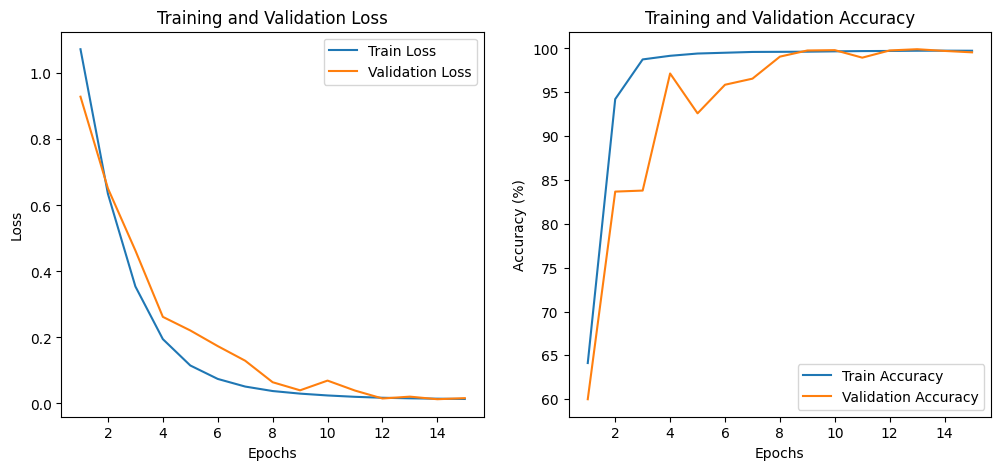

In [ ]:
# 모델 학습
trained_model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

In [ ]:
# 최종 테스트 평가

print("Final evaluation on the test set...")
test_loss, test_accuracy = evaluate_model(trained_model, test_loader, criterion)
print(f'Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_accuracy:.2f}%')

Final evaluation on the test set...
Final Test Loss: 0.0130, Final Test Accuracy: 99.68%


In [ ]:
# 모델 크기 출력
model_size = get_model_size(trained_model)
print(f'Model size: {model_size:.2f} MB')

Model size: 11.73 MB


In [ ]:
# Teacher 모델 가중치 저장
torch.save(trained_model.state_dict(), "/content/drive/MyDrive/new model 11kw/teacher_model_2.pth")
print("모델 가중치 저장 완료!")

모델 가중치 저장 완료!


In [ ]:
# 비제로 가중치 수 계산
nonzero_weights, total_weights = count_nonzero_weights(trained_model)
print(f"Number of non-zero weights: {nonzero_weights}")
print(f"Total number of weights: {total_weights}")
print(f"Percentage of non-zero weights: {100 * nonzero_weights / total_weights:.2f}%")

Number of non-zero weights: 3073701
Total number of weights: 3073701
Percentage of non-zero weights: 100.00%


In [ ]:
# 모델 평가 함수 (혼동 행렬 포함)
def evaluate_model(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 샘플 수 기반 loss 누적
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    conf_matrix = confusion_matrix(all_labels, all_predictions)
    accuracy = 100 * correct / total

    # 전체 샘플 수로 나누기
    return val_loss / total, accuracy, conf_matrix

In [ ]:
# 혼동 행렬 시각화 함수


# 평가 및 시각화 예시
test_loss, test_accuracy, test_conf_matrix = evaluate_model(model, test_loader, criterion)
print(f"test Loss: {test_loss:.4f}")
print(f"test Accuracy: {test_accuracy:.2f}%")
print("Confusion Matrix:")
print(test_conf_matrix)


test Loss: 0.0130
test Accuracy: 99.68%
Confusion Matrix:
[[3600    0    0    0    0]
 [   0 3547    0   53    0]
 [   0    0 3595    1    4]
 [   0    0    0 3600    0]
 [   0    0    0    0 3600]]


In [ ]:
# 혼동 행렬 시각화
def plot_confusion_matrix(conf_matrix, label_encoder, title="Confusion Matrix"):
    categories = label_encoder.classes_
    plt.figure(figsize=(7, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=categories, yticklabels=categories,
                linewidths=0.5, linecolor='gray')

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

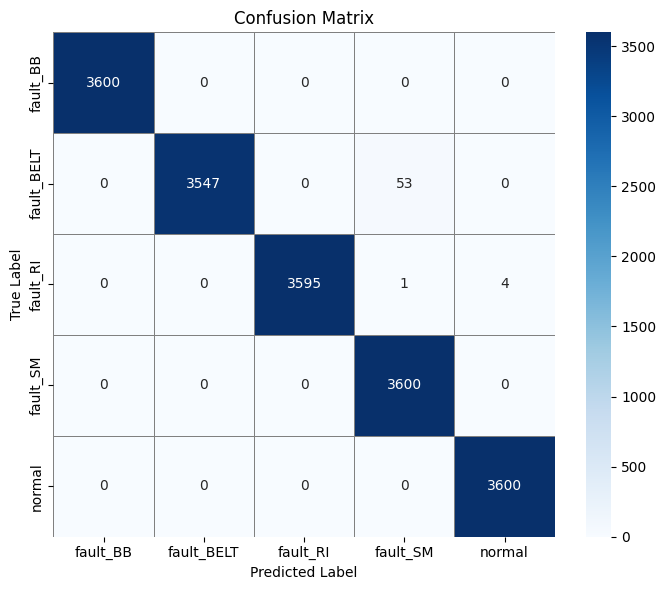

In [ ]:
# 혼동 행렬 시각화
label_encoder = LabelEncoder()
label_encoder.fit(categories)
plot_confusion_matrix(test_conf_matrix, label_encoder)

In [ ]:
from fvcore.nn import FlopCountAnalysis, flop_count_table

# FLOPs 계산 함수
def calculate_flops(model, input_size):
    model.eval()  # 평가 모드로 전환
    dummy_input = torch.randn(*input_size).to(device)  # 가짜 입력 생성
    flops = FlopCountAnalysis(model, dummy_input)
    return flops

# 입력 크기 정의 (배치 크기, 채널, 길이)
input_size = (1, 1, input_length)  # 배치 크기 1, 채널 1, input_length 사용

# FLOPs 계산
flops = calculate_flops(trained_model, input_size)

# 결과 출력
print(f"Total FLOPs: {flops.total() / 1e6:.2f} MFLOPs")  # FLOPs를 MegaFLOPs 단위로 변환
print(flop_count_table(flops))

Total FLOPs: 6.59 MFLOPs
| module         | #parameters or shape   | #flops   |
|:---------------|:-----------------------|:---------|
| model          | 3.074M                 | 6.586M   |
|  conv1         |  64                    |  71.904K |
|   conv1.weight |   (16, 1, 3)           |          |
|   conv1.bias   |   (16,)                |          |
|  conv2         |  1.568K                |  1.15M   |
|   conv2.weight |   (32, 16, 3)          |          |
|   conv2.bias   |   (32,)                |          |
|  conv3         |  6.208K                |  2.298M  |
|   conv3.weight |   (64, 32, 3)          |          |
|   conv3.bias   |   (64,)                |          |
|  fc1           |  3.064M                |  3.064M  |
|   fc1.weight   |   (256, 11968)         |          |
|   fc1.bias     |   (256,)               |          |
|  bn1           |  0.512K                |  0.512K  |
|   bn1.weight   |   (256,)               |          |
|   bn1.bias     |   (256,)             

In [ ]:
print("\nCalculating F1 Score...")
calculate_f1_score(trained_model, test_loader, device)


Calculating F1 Score...
F1 Score: 0.9968


In [ ]:
# 파라미터 수 계산 함수
def calculate_total_params(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total Parameters: {total_params:,}")

In [ ]:
print("\nCalculating Total Parameters...")
calculate_total_params(trained_model)


Calculating Total Parameters...
Total Parameters: 3,073,701


In [ ]:
# 자원 제한 설정 함수
def setup_limited_resources(cpu_only=True, num_threads=2):
    if cpu_only:
        device = torch.device("cpu")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # CPU 환경일 경우 스레드 수 제한
    if device.type == "cpu":
        torch.set_num_threads(num_threads)
        print(f"CPU 환경: 스레드 수를 {num_threads}개로 제한합니다.")
    else:
        print(f"GPU 환경: {torch.cuda.get_device_name(0)} 사용 중.")

    return device

In [ ]:
# 추론 시간 측정 함수
def measure_inference_time(model, input_data, device, iterations=100):
    model.eval()
    model.to(device)
    input_data = input_data.to(device)

    # 추론 시간 측정
    with torch.no_grad():
        start_time = time.time()
        for _ in range(iterations):
            _ = model(input_data)
        end_time = time.time()

    avg_time = (end_time - start_time) / iterations
    print(f"Average Inference Time: {avg_time * 1000:.2f} ms")
    return avg_time

In [ ]:
# 1. 모델 저장
torch.save(model, "trained_model.pth")
print("Model saved as 'trained_model.pth'")

# 2. CPU 환경 설정
device_cpu = setup_limited_resources(cpu_only=True, num_threads=2)

# 3. 모델 로드
model = torch.load("trained_model.pth", map_location=device_cpu, weights_only=False)
model.to(device_cpu)
model.eval()
print("Model loaded and moved to CPU.")

Model saved as 'trained_model.pth'
CPU 환경: 스레드 수를 2개로 제한합니다.
Model loaded and moved to CPU.


In [ ]:
# 데이터 로더에서 샘플 데이터 가져오기
for input_data, _ in test_loader:
    break  # 첫 번째 배치만 가져옴

# 배치에서 첫 번째 샘플 선택 (배치 크기 1로 설정)
input_data = input_data[0:1].to(device_cpu)

In [ ]:
# 5. 제한된 환경에서 추론 시간 측정
print("\nMeasuring Inference Time on CPU...")
measure_inference_time(model, input_data, device_cpu, iterations=100)


Measuring Inference Time on CPU...
Average Inference Time: 4.15 ms


0.004149563312530517